In [30]:
## Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import seaborn as sns
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from keras.callbacks import EarlyStopping
import tensorflow as tf

## Load data

In [31]:
data = pd.read_csv("./MSFT.csv")


In [32]:
data.shape

(5999, 7)

In [33]:
data["Date"]= pd.to_datetime(data["Date"])
data = data.set_index('Date')
data = data.sort_values(by = ['Date'])
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,36.205593,53228400
2000-01-04,56.78125,58.5625,56.12500,56.31250,34.982559,54119000
2000-01-05,55.56250,58.1875,54.68750,56.90625,35.351421,64059600
2000-01-06,56.09375,56.9375,54.18750,55.00000,34.167217,54976600
2000-01-07,54.31250,56.1250,53.65625,55.71875,34.613728,62013600


In [34]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5.999000e+03
mean,77.139668,77.949712,76.316865,77.156730,70.286945,5.137814e+07
std,86.048453,86.933727,85.126860,86.069734,87.619441,3.076160e+07
min,15.200000,15.620000,14.870000,15.150000,11.327565,7.425600e+06
25%,27.030001,27.295000,26.799999,27.045000,19.058252,2.875525e+07
50%,32.494999,32.937500,32.125000,32.590000,23.640200,4.612340e+07
75%,83.645001,84.184998,83.110001,83.840001,78.063667,6.507830e+07
max,361.750000,366.779999,352.440002,359.489990,358.730469,5.910522e+08


In [35]:
# check null
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

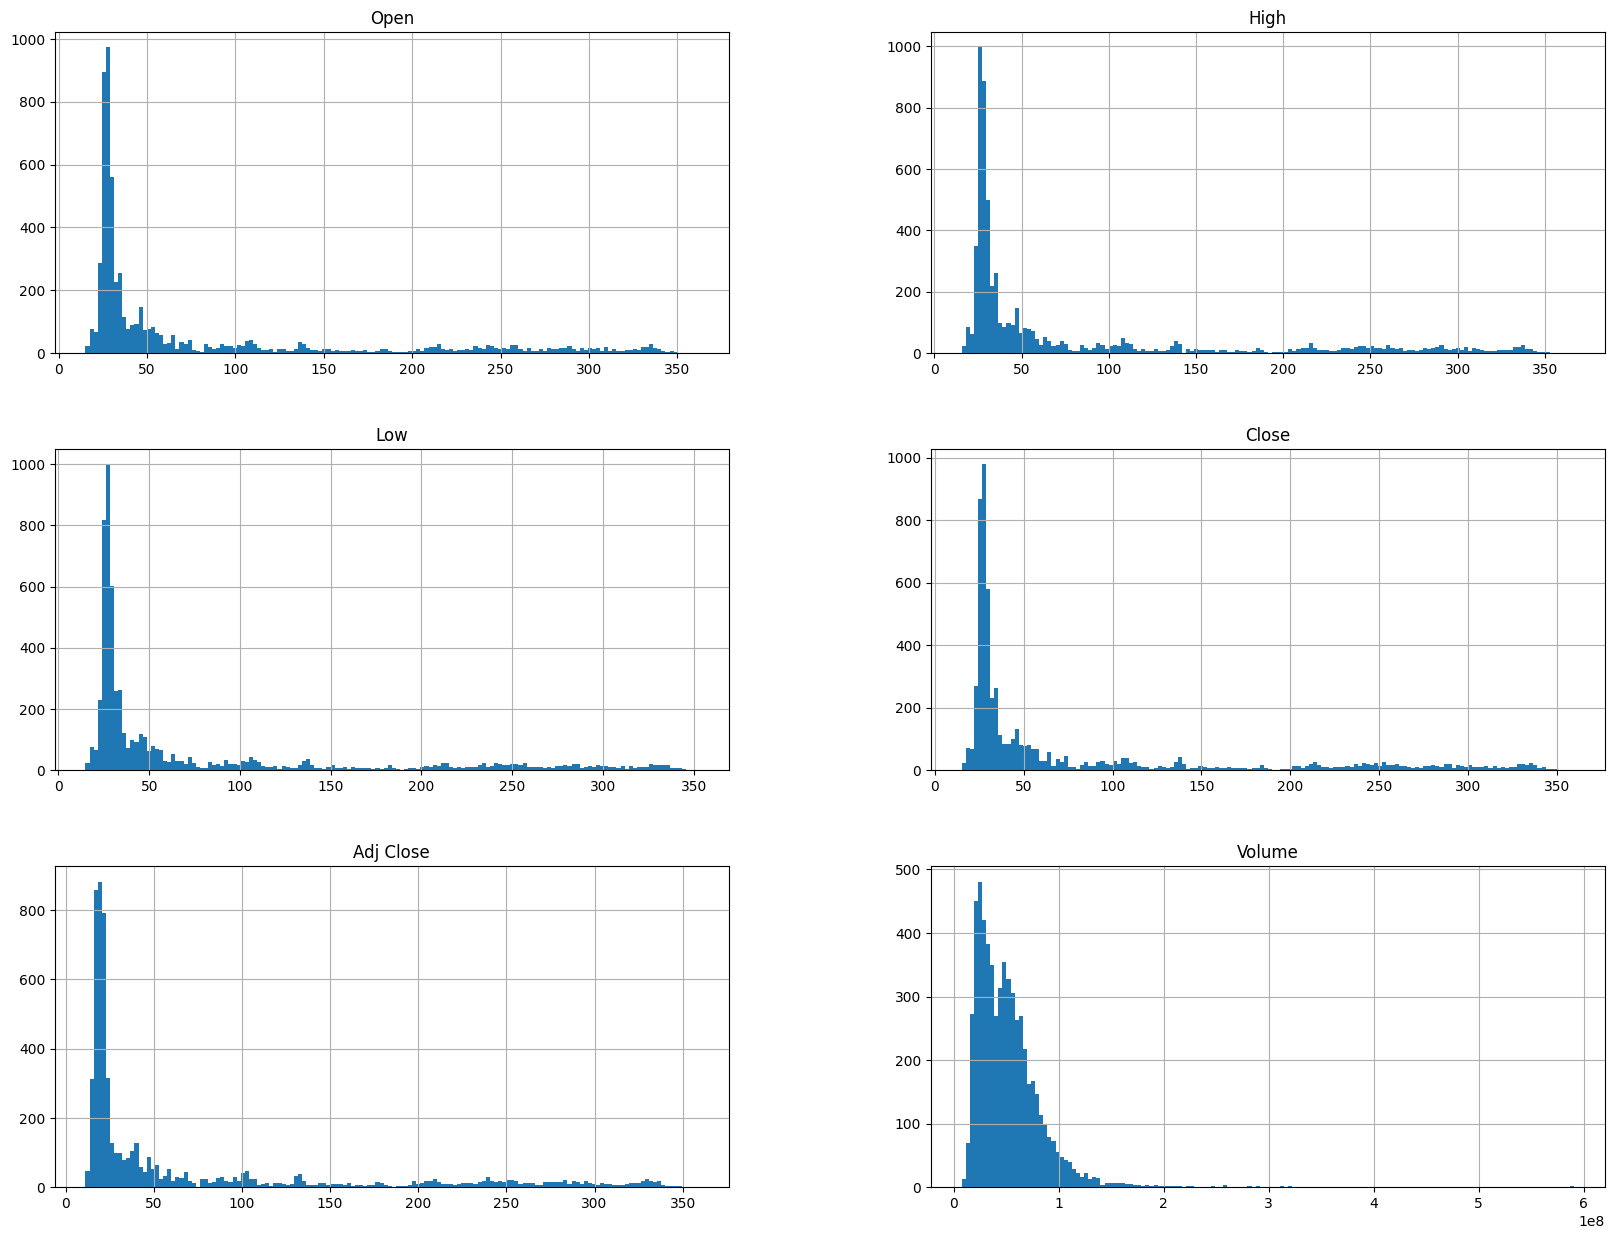

In [36]:
data.hist(bins = 150, figsize = (20,15))
plt.show()

In [19]:
df1 = data['High']
df1

0        59.312500
1        58.562500
2        58.187500
3        56.937500
4        56.125000
           ...    
5994    339.450012
5995    339.000000
5996    347.420013
5997    348.829987
5998    354.390015
Name: High, Length: 5999, dtype: float64

In [20]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
training_size = int(len(df1)*0.95)

test_size = len(df1) - training_size

train_data, test_data = df1[0:training_size,:], df1[training_size:,:]  
                                                                    
print(len(train_data))
print(len(test_data))

5699
300
